In [1]:
import gym
import numpy as np
from blackjack_env import BlackjackEnv 
from blackjack_double_env import BlackjackDoubleEnv
from blackjack_double_env_count import BlackjackDoubleEnvWithCount

from tqdm import tqdm 
from collections import defaultdict
import random
from matplotlib import pyplot as plt

In [2]:
MEAN = 100_000

1. Рассмотрим очень простую стратегию: говорить stand, если у нас на руках комбинация в 19, 20 или 21 очко, во всех остальных случаях говорить hit. Используйте методы Монте-Карло, чтобы оценить выигрыш от этой стратегии.


In [3]:
def simple_policy(env):
    player, _, _ = env._get_obs()
    return player < 19


def run_episode_simple(env, policy):
    env.reset()
    state = env._get_obs()
    rewards = [] 
    terminated = False
    
    while not terminated:
        action = policy(env)
        state, reward, terminated, _, _ = env.step(action)
        rewards.append(reward)
    return rewards


def run_experiments_simple(env, policy, num_experiments = 500_000):
    all_rewards = []
    
    for i in tqdm(range(num_experiments)):
        rewards = run_episode_simple(env, policy)
        all_rewards.append(rewards[-1])

    mean_reward = np.mean(all_rewards)

    print(f"mean reward: {mean_reward}")
    return mean_reward

In [4]:
env = BlackjackEnv(natural=True)
run_experiments_simple(env, simple_policy)
env.close()

100%|████████████████████████████████| 500000/500000 [00:38<00:00, 13086.70it/s]

mean reward: -0.181507


2. Реализуйте метод обучения с подкреплением без модели (можно Q-обучение, но рекомендую попробовать и другие, например Monte Carlo control) для обучения стратегии в блекджеке, используя окружение BlackjackEnv из OpenAI Gym.


In [5]:
def epsilon_greedy_policy(env, epsilon, Q):
    state = env._get_obs()
    if random.random() > epsilon:
        return Q[state].argmax()
    else:
        return random.randint(0, env.action_space.n - 1)
    

def run_episode_mc_control(env, policy, epsilon, Q):
    env.reset()
    state = env._get_obs()
    episode = []
    
    terminated = False
    while not terminated:
        action = policy(env, epsilon, Q)
        next_state, reward, terminated, _, _ = env.step(action)
        episode.append((state, action, reward))
        state = next_state
    return episode


def run_experiments_mc_control(env, policy, number_of_experiments, gamma, epsilon):
    alpha = 0.9
    
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    state_action_counter = defaultdict(int)
    
    mean_game_rewards = []
    
    for i in tqdm(range(number_of_experiments + 1)):
        episode = run_episode_mc_control(env, policy, epsilon, Q)
        G = 0
        for state, action, reward in reversed(episode):
            G = reward + gamma * G
            state_action_counter[(state, action)] += 1
            Q[state][action] = Q[state][action] + (G - Q[state][action]) * alpha / state_action_counter[(state, action)]
        
        if (i % MEAN == 0):
            evaluation = evaluate(env, policy, Q, epsilon)
            mean_game_rewards.append(evaluation)
            print(evaluation)
    return mean_game_rewards


def evaluate(env, policy, Q, epsilon, iterations = MEAN):
    rewards = []
    for _ in range(iterations):
        state = env.reset()
        terminated = False
        while not terminated:
            action = policy(env, epsilon, Q)
            state, reward, terminated, _, _ = env.step(action)
            rewards.append(reward)
    reward_result = np.mean(rewards)
    return reward_result


def plot(results_dict, title):
    fig = plt.figure(figsize = (14, 8))
    for result in results_dict:
        mean = results_dict[result]
        plt.plot(np.array(list(range(1, (len(mean)) * MEAN, MEAN))), mean, label = f"gamma = {result[0]}, epsilon = {result[1]}")
        plt.legend()
        plt.title(title)
        plt.ylabel("reward")
        plt.xlabel("experiments")
        plt.grid(True)

3. Сколько выигрывает казино у вашей стратегии? Нарисуйте графики среднего дохода вашего метода (усреднённого по крайней мере по 100000 раздач, а лучше больше) по ходу обучения. Попробуйте подобрать оптимальные гиперпараметры.

In [6]:
gammas = [1, 0.6, 0.2]
epsilons = [0.0, 0.001, 0.005]

results_dict = defaultdict() 
for gamma in gammas:
    for epsilon in epsilons:
        env = BlackjackEnv(natural=True)
        print(f"current experiment gamma = {gamma}, epsilon = {epsilon}")
        mean_game_rewards_mc = run_experiments_mc_control(env, epsilon_greedy_policy, 500_000, gamma, epsilon)
        results_dict[(gamma, epsilon)] = mean_game_rewards_mc
        print(f"current experiment with gamma = {gamma}, epsilon = {epsilon} has finished")
        env.close()

current experiment gamma = 1, epsilon = 0.0


  1%|▏                                   | 2547/500001 [00:06<13:20, 621.26it/s]

-0.1610648276407963


 20%|██████▉                           | 101824/500001 [00:22<09:00, 737.28it/s]

-0.06894828045854438


 40%|█████████████▊                    | 202245/500001 [00:38<06:36, 751.58it/s]

-0.0644207249277296


 60%|████████████████████▌             | 302458/500001 [00:53<04:10, 788.30it/s]

-0.06403644809189193


 80%|███████████████████████████▎      | 401599/500001 [01:08<02:09, 757.13it/s]

-0.06677787663107948


100%|█████████████████████████████████| 500001/500001 [01:24<00:00, 5951.27it/s]


-0.06655806893487838
current experiment with gamma = 1, epsilon = 0.0 has finished
current experiment gamma = 1, epsilon = 0.001


  0%|▏                                   | 2413/500001 [00:06<13:56, 594.59it/s]

-0.16565138931815235


 20%|██████▉                           | 102432/500001 [00:22<08:43, 759.10it/s]

-0.07059204840103717


 40%|█████████████▋                    | 201813/500001 [00:37<06:39, 746.63it/s]

-0.06365831701984767


 60%|████████████████████▍             | 301428/500001 [00:52<04:15, 778.10it/s]

-0.0672168546316625


 80%|███████████████████████████▎      | 401855/500001 [01:08<02:11, 745.05it/s]

-0.06391422901765957


100%|█████████████████████████████████| 500001/500001 [01:23<00:00, 5990.24it/s]


-0.06086791444602253
current experiment with gamma = 1, epsilon = 0.001 has finished
current experiment gamma = 1, epsilon = 0.005


  1%|▏                                   | 2536/500001 [00:06<13:11, 628.66it/s]

-0.16657180516445988


 20%|██████▉                           | 101915/500001 [00:21<08:13, 807.43it/s]

-0.05347712080363408


 40%|█████████████▋                    | 201481/500001 [00:37<06:44, 738.44it/s]

-0.04436910061378625


 60%|████████████████████▍             | 301266/500001 [00:53<04:35, 721.53it/s]

-0.04290857958540171


 80%|███████████████████████████▎      | 401717/500001 [01:08<02:13, 736.94it/s]

-0.03754277091790109


100%|█████████████████████████████████| 500001/500001 [01:24<00:00, 5945.83it/s]


-0.036813804737471006
current experiment with gamma = 1, epsilon = 0.005 has finished
current experiment gamma = 0.6, epsilon = 0.0


  1%|▏                                   | 2506/500001 [00:06<13:17, 623.99it/s]

-0.1621


 20%|██████▉                           | 101741/500001 [00:22<08:47, 754.65it/s]

-0.04514376996805112


 40%|█████████████▋                    | 201797/500001 [00:37<06:38, 747.57it/s]

-0.04585215710866811


 60%|████████████████████▌             | 301723/500001 [00:53<04:40, 707.60it/s]

-0.04312870172565975


 80%|███████████████████████████▎      | 401973/500001 [01:09<02:09, 759.75it/s]

-0.04313054143138207


100%|█████████████████████████████████| 500001/500001 [01:24<00:00, 5886.34it/s]


-0.04041169473966926
current experiment with gamma = 0.6, epsilon = 0.0 has finished
current experiment gamma = 0.6, epsilon = 0.001


  0%|▏                                   | 2320/500001 [00:06<14:17, 580.34it/s]

-0.16516526990264171


 20%|██████▉                           | 102198/500001 [00:22<09:14, 717.97it/s]

-0.049351140229305784


 40%|█████████████▋                    | 201672/500001 [00:38<07:12, 689.88it/s]

-0.04029551524840918


 60%|████████████████████▍             | 301384/500001 [00:54<04:28, 738.63it/s]

-0.039574370883618225


 80%|███████████████████████████▎      | 401571/500001 [01:10<02:22, 691.66it/s]

-0.03383807857483696


100%|█████████████████████████████████| 500001/500001 [01:26<00:00, 5808.79it/s]


-0.03053848013948812
current experiment with gamma = 0.6, epsilon = 0.001 has finished
current experiment gamma = 0.6, epsilon = 0.005


  1%|▏                                   | 2517/500001 [00:06<13:03, 635.19it/s]

-0.16702071427859058


 20%|██████▉                           | 101566/500001 [00:22<09:20, 711.14it/s]

-0.03573883823879005


 40%|█████████████▋                    | 201575/500001 [00:38<07:26, 667.93it/s]

-0.027897190799641543


 60%|████████████████████▌             | 301481/500001 [00:54<04:39, 709.89it/s]

-0.027985474577262127


 80%|███████████████████████████▎      | 401773/500001 [01:10<02:14, 728.47it/s]

-0.02974180442975552


100%|█████████████████████████████████| 500001/500001 [01:26<00:00, 5765.86it/s]


-0.022319333646175506
current experiment with gamma = 0.6, epsilon = 0.005 has finished
current experiment gamma = 0.2, epsilon = 0.0


  0%|▏                                   | 2413/500001 [00:06<13:53, 596.70it/s]

-0.155145175692516


 20%|██████▉                           | 101294/500001 [00:22<09:22, 708.70it/s]

-0.0317973324450025


 40%|█████████████▊                    | 202316/500001 [00:38<06:44, 735.18it/s]

-0.027771732869084347


 60%|████████████████████▌             | 302174/500001 [00:53<04:33, 723.50it/s]

-0.03230421398188716


 80%|███████████████████████████▎      | 401857/500001 [01:09<02:13, 737.21it/s]

-0.03133423611022395


100%|█████████████████████████████████| 500001/500001 [01:25<00:00, 5880.64it/s]


-0.028578536753401676
current experiment with gamma = 0.2, epsilon = 0.0 has finished
current experiment gamma = 0.2, epsilon = 0.001


  0%|▏                                   | 2398/500001 [00:06<14:04, 589.29it/s]

-0.1661068122288205


 20%|██████▉                           | 101515/500001 [00:22<09:42, 684.60it/s]

-0.0353378991149889


 40%|█████████████▊                    | 202428/500001 [00:39<05:03, 980.84it/s]

-0.03364478939040012


 60%|████████████████████▌             | 301476/500001 [00:55<04:48, 687.41it/s]

-0.030360716398373882


 80%|███████████████████████████▎      | 401347/500001 [01:11<02:24, 681.22it/s]

-0.03670333958535265


100%|█████████████████████████████████| 500001/500001 [01:27<00:00, 5743.97it/s]


-0.031038787450822152
current experiment with gamma = 0.2, epsilon = 0.001 has finished
current experiment gamma = 0.2, epsilon = 0.005


  0%|▏                                   | 2235/500001 [00:07<16:03, 516.41it/s]

-0.1688699402919504


 20%|██████▉                           | 101303/500001 [00:23<09:44, 682.56it/s]

-0.032925334276975964


 40%|█████████████▋                    | 202186/500001 [00:39<06:51, 724.04it/s]

-0.0245253164556962


 60%|████████████████████▌             | 301632/500001 [00:55<04:51, 680.20it/s]

-0.021377460319483118


 80%|███████████████████████████▎      | 401530/500001 [01:12<02:27, 668.65it/s]

-0.02544664940671596


100%|█████████████████████████████████| 500001/500001 [01:27<00:00, 5689.12it/s]

-0.02088248198854134
current experiment with gamma = 0.2, epsilon = 0.005 has finished


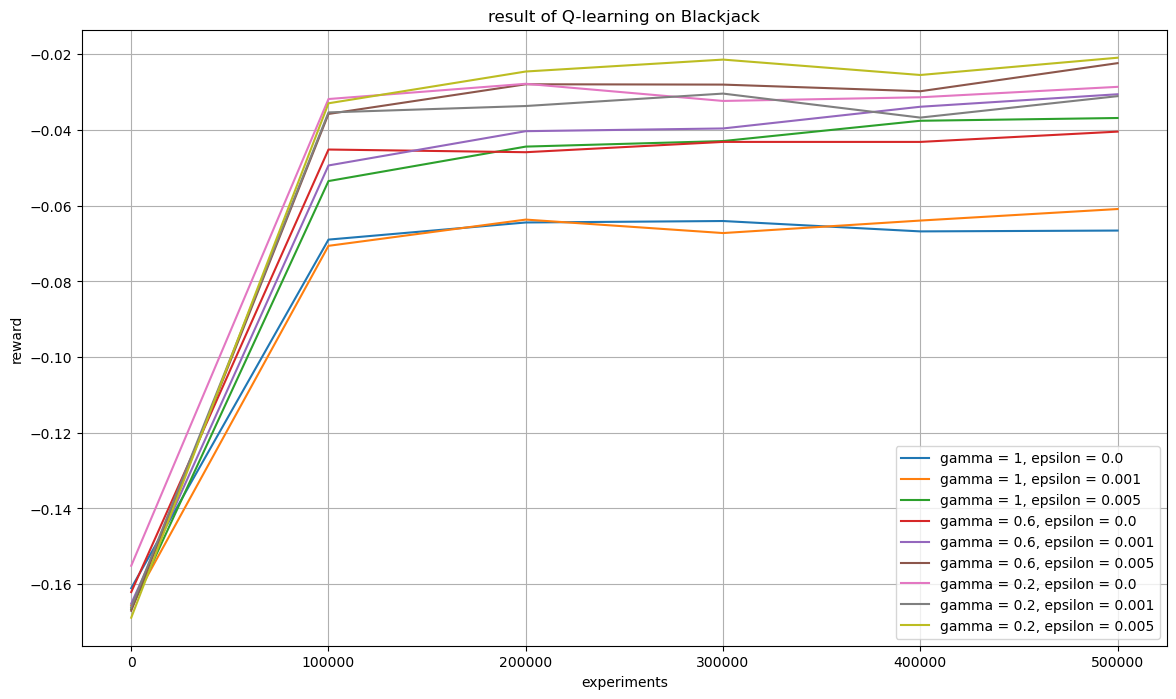

In [7]:
plot(results_dict, "result of Q-learning on Blackjack")

4. Реализуйте новый вариант блекджека на основе окружения BlackjackEnv из OpenAI Gym, в котором разрешено удвоение ставки.


Находится в файле blackjack_double_env.py

5. Реализуйте метод обучения с подкреплением без модели для этого варианта, постройте графики, аналогичные п.2.


In [8]:
gammas = [1, 0.6, 0.2]
epsilons = [0.0, 0.001, 0.005]
results_dict = defaultdict() 
for gamma in gammas:
    for epsilon in epsilons:
        env = BlackjackDoubleEnv(natural=True)
        print(f"current experiment gamma = {gamma}, epsilon = {epsilon}")
        mean_game_rewards_mc = run_experiments_mc_control(env, epsilon_greedy_policy, 1_000_000, gamma, epsilon)
        results_dict[(gamma, epsilon)] = mean_game_rewards_mc
        print(f"current experiment with gamma = {gamma}, epsilon = {epsilon} has finished")
        env.close()

current experiment gamma = 1, epsilon = 0.0


  0%|                                   | 2512/1000001 [00:08<31:12, 532.68it/s]

-0.5162749020588481


 10%|███▎                             | 101930/1000001 [00:23<20:18, 737.10it/s]

-0.10708433229199461


 20%|██████▋                          | 201740/1000001 [00:38<16:32, 803.94it/s]

-0.10913239064187936


 30%|█████████▉                       | 302470/1000001 [00:53<14:22, 808.95it/s]

-0.11183139675428276


 40%|█████████████▎                   | 401864/1000001 [01:08<12:07, 822.17it/s]

-0.11056658478637298


 50%|████████████████▌                | 502368/1000001 [01:24<11:37, 713.82it/s]

-0.11301306458234389


 60%|███████████████████▊             | 602114/1000001 [01:39<08:47, 754.22it/s]

-0.11279081023522958


 70%|███████████████████████▏         | 701840/1000001 [01:55<06:26, 771.72it/s]

-0.10904604336239725


 80%|██████████████████████████▍      | 802152/1000001 [02:11<04:20, 758.04it/s]

-0.11150002413942935


 90%|█████████████████████████████▊   | 901716/1000001 [02:26<02:03, 798.27it/s]

-0.11249798484604223


100%|███████████████████████████████| 1000001/1000001 [02:41<00:00, 6204.13it/s]


-0.11204207005242675
current experiment with gamma = 1, epsilon = 0.0 has finished
current experiment gamma = 1, epsilon = 0.001


  0%|                                   | 2168/1000001 [00:08<36:52, 451.07it/s]

-0.5011152126442757


 10%|███▎                             | 102036/1000001 [00:23<20:28, 730.69it/s]

-0.09771015227257021


 20%|██████▋                          | 202318/1000001 [00:39<17:28, 760.84it/s]

-0.08272875390030587


 30%|█████████▉                       | 301242/1000001 [00:54<15:09, 768.36it/s]

-0.08697062617306073


 40%|█████████████▎                   | 401874/1000001 [01:09<13:29, 738.49it/s]

-0.08124025437979637


 50%|████████████████▌                | 502414/1000001 [01:24<10:27, 792.69it/s]

-0.07769591938008169


 60%|███████████████████▊             | 602079/1000001 [01:40<09:09, 724.78it/s]

-0.07393938479413917


 70%|███████████████████████▏         | 701526/1000001 [01:56<06:45, 735.50it/s]

-0.07978107328594464


 80%|██████████████████████████▍      | 802138/1000001 [02:12<04:45, 694.08it/s]

-0.07697077863149616


 90%|█████████████████████████████▊   | 902346/1000001 [02:28<02:14, 726.02it/s]

-0.06907681413290596


100%|███████████████████████████████| 1000001/1000001 [02:43<00:00, 6117.40it/s]


-0.06380288938445819
current experiment with gamma = 1, epsilon = 0.001 has finished
current experiment gamma = 1, epsilon = 0.005


  0%|                                   | 2508/1000001 [00:07<30:31, 544.60it/s]

-0.4755596261078038


 10%|███▎                             | 101857/1000001 [00:23<20:05, 745.28it/s]

-0.07922746849450296


 20%|██████▍                         | 202545/1000001 [00:38<12:42, 1045.60it/s]

-0.06678478135629336


 30%|█████████▉                       | 301668/1000001 [00:54<15:27, 752.74it/s]

-0.05680828902776482


 40%|█████████████▏                   | 401337/1000001 [01:09<12:51, 775.78it/s]

-0.0478554771449039


 50%|████████████████▌                | 502363/1000001 [01:25<11:32, 718.84it/s]

-0.04909297912713473


 60%|███████████████████▊             | 601771/1000001 [01:40<08:49, 752.58it/s]

-0.04352826851099689


 70%|███████████████████████▏         | 701329/1000001 [01:56<06:58, 713.04it/s]

-0.04919297276139163


 80%|██████████████████████████▍      | 801856/1000001 [02:12<04:30, 731.21it/s]

-0.04437637389616178


 90%|█████████████████████████████▊   | 902032/1000001 [02:28<02:13, 735.17it/s]

-0.0427794002529054


100%|███████████████████████████████| 1000001/1000001 [02:43<00:00, 6101.92it/s]


-0.035777145700429995
current experiment with gamma = 1, epsilon = 0.005 has finished
current experiment gamma = 0.6, epsilon = 0.0


  0%|                                   | 2484/1000001 [00:07<31:13, 532.53it/s]

-0.517889237199582


 10%|███▎                             | 101650/1000001 [00:23<20:37, 726.11it/s]

-0.06556232368173588


 20%|██████▋                          | 201758/1000001 [00:39<18:59, 700.53it/s]

-0.06725191106146812


 30%|█████████▉                       | 301294/1000001 [00:55<16:02, 726.04it/s]

-0.06324614964002552


 40%|█████████████▎                   | 402185/1000001 [01:11<14:09, 703.43it/s]

-0.06143281624909324


 50%|████████████████▌                | 502082/1000001 [01:27<11:13, 739.21it/s]

-0.06214334984636609


 60%|███████████████████▊             | 601671/1000001 [01:43<09:02, 734.53it/s]

-0.06172860991416817


 70%|███████████████████████▏         | 701843/1000001 [01:59<07:12, 690.03it/s]

-0.06866695481226384


 80%|██████████████████████████▍      | 802225/1000001 [02:15<03:32, 931.97it/s]

-0.06930128805784373


 90%|█████████████████████████████▊   | 901862/1000001 [02:31<02:22, 691.09it/s]

-0.06611276460788892


100%|███████████████████████████████| 1000001/1000001 [02:47<00:00, 5963.89it/s]


-0.06350245955323923
current experiment with gamma = 0.6, epsilon = 0.0 has finished
current experiment gamma = 0.6, epsilon = 0.001


  0%|                                   | 2433/1000001 [00:08<32:28, 512.01it/s]

-0.5137947800991279


 10%|███▎                             | 101531/1000001 [00:24<21:56, 682.31it/s]

-0.05527345206538172


 20%|██████▋                          | 201645/1000001 [00:40<18:52, 705.09it/s]

-0.04207800668780705


 30%|█████████▉                       | 301298/1000001 [00:56<16:18, 713.82it/s]

-0.04132201229470106


 40%|█████████████▎                   | 401978/1000001 [01:12<15:03, 661.88it/s]

-0.038373299285799786


 50%|████████████████▌                | 501497/1000001 [01:28<12:18, 674.95it/s]

-0.040340412573153614


 60%|███████████████████▊             | 602051/1000001 [01:45<09:41, 684.26it/s]

-0.030628064131442957


 70%|███████████████████████▏         | 702071/1000001 [02:01<07:04, 702.48it/s]

-0.03188154692625119


 80%|██████████████████████████▍      | 802171/1000001 [02:17<04:52, 676.12it/s]

-0.0361574498015952


 90%|█████████████████████████████▊   | 901945/1000001 [02:34<02:25, 675.21it/s]

-0.027758804766609857


100%|███████████████████████████████| 1000001/1000001 [02:50<00:00, 5868.86it/s]


-0.027148386752919702
current experiment with gamma = 0.6, epsilon = 0.001 has finished
current experiment gamma = 0.6, epsilon = 0.005


  0%|                                   | 2363/1000001 [00:08<33:19, 498.96it/s]

-0.5183827949794294


 10%|███▎                             | 102162/1000001 [00:24<21:11, 705.90it/s]

-0.05649584160615359


 20%|██████▋                          | 202000/1000001 [00:40<18:24, 722.48it/s]

-0.05141705981610937


 30%|█████████▉                       | 302036/1000001 [00:56<16:08, 720.75it/s]

-0.03431166257144021


 40%|█████████████▏                   | 401218/1000001 [01:11<13:20, 747.72it/s]

-0.03340673725260266


 50%|████████████████▌                | 501576/1000001 [01:27<10:54, 761.36it/s]

-0.026915071484628246


 60%|███████████████████▊             | 601549/1000001 [01:43<09:17, 714.22it/s]

-0.03125256224548362


 70%|███████████████████████▏         | 701255/1000001 [01:59<07:03, 705.52it/s]

-0.027019536729736202


 80%|██████████████████████████▍      | 801921/1000001 [02:14<04:24, 749.94it/s]

-0.026245105447551008


 90%|█████████████████████████████▊   | 902325/1000001 [02:30<02:12, 739.90it/s]

-0.0230848638949126


100%|███████████████████████████████| 1000001/1000001 [02:45<00:00, 6028.22it/s]


-0.02361456605859591
current experiment with gamma = 0.6, epsilon = 0.005 has finished
current experiment gamma = 0.2, epsilon = 0.0


  0%|                                   | 2485/1000001 [00:07<30:46, 540.14it/s]

-0.5112501366255315


 10%|███▍                             | 102287/1000001 [00:23<21:28, 696.84it/s]

-0.06810771915077879


 20%|██████▋                          | 201385/1000001 [00:40<19:40, 676.51it/s]

-0.06834011557449197


 30%|█████████▉                       | 301268/1000001 [00:56<17:40, 658.93it/s]

-0.07064205018659445


 40%|█████████████▏                   | 401179/1000001 [01:13<15:03, 662.92it/s]

-0.06780329286672729


 50%|████████████████▌                | 501755/1000001 [01:29<11:40, 711.38it/s]

-0.06715501276021613


 60%|███████████████████▊             | 601245/1000001 [01:45<09:33, 695.81it/s]

-0.06895694731207463


 70%|███████████████████████▏         | 701646/1000001 [02:01<07:08, 696.44it/s]

-0.070837054995534


 80%|██████████████████████████▍      | 802107/1000001 [02:18<04:51, 679.15it/s]

-0.06754831693620701


 90%|█████████████████████████████▊   | 902111/1000001 [02:34<02:37, 621.97it/s]

-0.06855809273952192


100%|███████████████████████████████| 1000001/1000001 [02:50<00:00, 5855.13it/s]


-0.06570603899130902
current experiment with gamma = 0.2, epsilon = 0.0 has finished
current experiment gamma = 0.2, epsilon = 0.001


  0%|                                   | 2385/1000001 [00:08<33:57, 489.67it/s]

-0.49699800040722775


 10%|███▎                             | 101260/1000001 [00:23<19:56, 751.29it/s]

-0.04498564112065429


 20%|██████▋                          | 201870/1000001 [00:39<18:02, 737.45it/s]

-0.04207991307746838


 30%|█████████▉                       | 301442/1000001 [00:55<15:47, 737.52it/s]

-0.033738187142286706


 40%|█████████████▎                   | 402089/1000001 [01:11<13:16, 750.94it/s]

-0.03848300051815537


 50%|████████████████▌                | 501905/1000001 [01:27<12:36, 658.57it/s]

-0.033555753459253254


 60%|███████████████████▊             | 601891/1000001 [01:43<09:00, 736.89it/s]

-0.03495250044810898


 70%|███████████████████████▏         | 701445/1000001 [01:59<07:21, 676.10it/s]

-0.03727010960430986


 80%|██████████████████████████▍      | 801757/1000001 [02:16<04:43, 700.32it/s]

-0.0338109821333048


 90%|█████████████████████████████▊   | 901886/1000001 [02:31<02:10, 751.67it/s]

-0.03233442710774794


100%|███████████████████████████████| 1000001/1000001 [02:47<00:00, 5962.25it/s]


-0.03481489417263152
current experiment with gamma = 0.2, epsilon = 0.001 has finished
current experiment gamma = 0.2, epsilon = 0.005


  0%|                                   | 2370/1000001 [00:07<32:38, 509.47it/s]

-0.5181434444856571


 10%|███▎                             | 101514/1000001 [00:23<21:00, 712.56it/s]

-0.04033827946731297


 20%|██████▋                          | 201390/1000001 [00:39<18:35, 716.07it/s]

-0.03674080828475592


 30%|█████████▉                       | 302152/1000001 [00:55<15:33, 747.20it/s]

-0.03372923024195409


 40%|█████████████▏                   | 401311/1000001 [01:11<14:23, 693.17it/s]

-0.02887020295443295


 50%|████████████████▌                | 501326/1000001 [01:27<12:08, 684.59it/s]

-0.028030621908870883


 60%|███████████████████▊             | 601779/1000001 [01:44<09:31, 696.91it/s]

-0.022805464793606216


 70%|███████████████████████▏         | 701770/1000001 [02:00<07:09, 693.77it/s]

-0.018003131558783355


 80%|██████████████████████████▍      | 802141/1000001 [02:16<04:36, 716.28it/s]

-0.022959714034699447


 90%|█████████████████████████████▋   | 901383/1000001 [02:32<02:12, 744.41it/s]

-0.02469371232042609


100%|███████████████████████████████| 1000001/1000001 [02:48<00:00, 5931.30it/s]

-0.024508846488008242
current experiment with gamma = 0.2, epsilon = 0.005 has finished


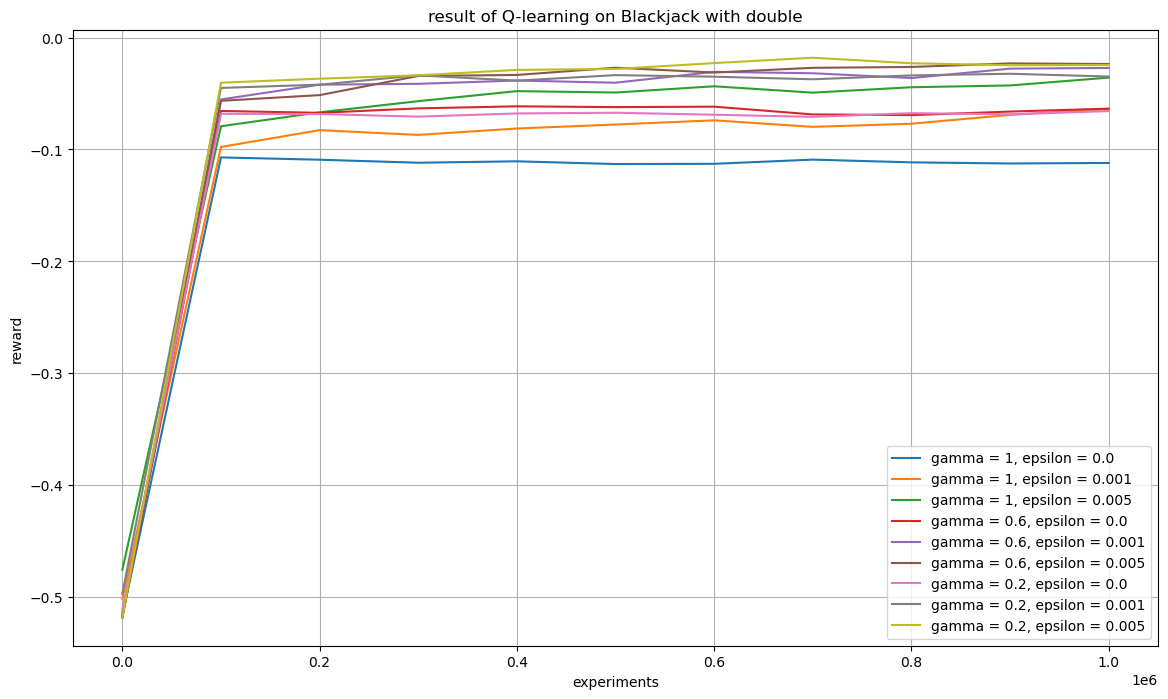

In [9]:
plot(results_dict, "result of Q-learning on Blackjack with double")

6. Реализуйте вариант окружения BlackjackEnv из предыдущей части (с удвоением), в котором игрок имеет возможность “считать карты” в колоде. Это можно сделать разными способами; возможно, вам поможет статья википедии о блекджеке (а возможно, и нет).



Находится в файле blackjack_double_env_count.py

7. Реализуйте метод обучения с подкреплением без модели для этого варианта, постройте графики, аналогичные п.2.

In [10]:
gammas = [1, 0.6, 0.2]
epsilon = 0.005
results_dict = defaultdict() 
for gamma in gammas:
    env = BlackjackDoubleEnvWithCount(natural=True)
    print(f"current experiment gamma = {gamma}, epsilon = {epsilon}")
    mean_game_rewards_mc = run_experiments_mc_control(env, epsilon_greedy_policy, 5_000_000, gamma, epsilon)
    results_dict[(gamma, epsilon)] = mean_game_rewards_mc
    print(f"current experiment with gamma = {gamma}, epsilon = {epsilon} has finished")
    env.close()

current experiment gamma = 1, epsilon = 0.005


  0%|                                  | 4458/5000001 [00:04<46:34, 1787.94it/s]

-0.518973680909775


  2%|▋                               | 102902/5000001 [00:12<31:49, 2564.43it/s]

-0.10923511171185497


  4%|█▎                              | 203616/5000001 [00:20<29:59, 2664.89it/s]

-0.08417368608375846


  6%|█▉                              | 302899/5000001 [00:28<30:13, 2589.64it/s]

-0.08305457815926913


  8%|██▌                             | 402396/5000001 [00:36<31:15, 2451.14it/s]

-0.07759193357058125


 10%|███▏                            | 502357/5000001 [00:45<29:43, 2521.13it/s]

-0.071900904517866


 12%|███▊                            | 604170/5000001 [00:53<28:38, 2557.38it/s]

-0.06697274392496914


 14%|████▌                           | 703232/5000001 [01:01<27:25, 2610.71it/s]

-0.06937295181811752


 16%|█████▏                          | 803524/5000001 [01:09<28:10, 2482.68it/s]

-0.06903621082397297


 18%|█████▊                          | 902777/5000001 [01:17<24:46, 2757.13it/s]

-0.07032233199093883


 20%|██████▏                        | 1002549/5000001 [01:25<26:07, 2550.96it/s]

-0.06434983208311101


 22%|██████▊                        | 1103004/5000001 [01:33<26:02, 2494.58it/s]

-0.05876541474348461


 24%|███████▍                       | 1202818/5000001 [01:42<25:04, 2523.70it/s]

-0.06732451344850207


 26%|████████                       | 1303347/5000001 [01:50<23:33, 2615.33it/s]

-0.057671734563996845


 28%|████████▋                      | 1402771/5000001 [01:58<21:59, 2726.00it/s]

-0.05765936979423289


 30%|█████████▎                     | 1503287/5000001 [02:06<21:38, 2691.92it/s]

-0.061275649370776765


 32%|█████████▉                     | 1603667/5000001 [02:14<22:26, 2521.58it/s]

-0.05270555981506006


 34%|██████████▌                    | 1702552/5000001 [02:22<21:04, 2607.40it/s]

-0.052999137160642196


 36%|███████████▏                   | 1803195/5000001 [02:30<20:51, 2553.62it/s]

-0.05581646423751687


 38%|███████████▊                   | 1903097/5000001 [02:38<19:36, 2631.89it/s]

-0.055385755302398816


 40%|████████████▍                  | 2004228/5000001 [02:47<20:08, 2479.67it/s]

-0.051487932875901865


 42%|█████████████                  | 2103051/5000001 [02:55<20:22, 2369.92it/s]

-0.05492511609312052


 44%|█████████████▋                 | 2204154/5000001 [03:03<17:25, 2673.13it/s]

-0.04838981751265144


 46%|██████████████▎                | 2303350/5000001 [03:12<17:57, 2503.82it/s]

-0.05020883626470476


 48%|██████████████▉                | 2404395/5000001 [03:20<15:51, 2728.06it/s]

-0.048894446916573325


 50%|███████████████▌               | 2503432/5000001 [03:28<16:17, 2552.95it/s]

-0.04509151669374866


 52%|████████████████▏              | 2603935/5000001 [03:36<16:38, 2398.55it/s]

-0.04482753341396574


 54%|████████████████▊              | 2702387/5000001 [03:44<15:24, 2484.00it/s]

-0.04278890247630694


 56%|█████████████████▍             | 2803768/5000001 [03:53<14:21, 2550.23it/s]

-0.04353753446419161


 58%|██████████████████             | 2904549/5000001 [04:01<12:53, 2709.39it/s]

-0.040861994037861865


 60%|██████████████████▌            | 3002667/5000001 [04:09<13:11, 2522.63it/s]

-0.0441709874233527


 62%|███████████████████▏           | 3103972/5000001 [04:17<12:26, 2538.84it/s]

-0.03940496069416169


 64%|███████████████████▊           | 3203423/5000001 [04:25<11:02, 2713.63it/s]

-0.041790350027089515


 66%|████████████████████▍          | 3303596/5000001 [04:33<10:20, 2733.63it/s]

-0.044238275294261144


 68%|█████████████████████          | 3404000/5000001 [04:41<09:48, 2713.45it/s]

-0.03912530450669915


 70%|█████████████████████▋         | 3502980/5000001 [04:49<09:57, 2507.12it/s]

-0.03746070887655928


 72%|██████████████████████▎        | 3603541/5000001 [04:57<08:55, 2609.40it/s]

-0.036979099101848954


 74%|██████████████████████▉        | 3703738/5000001 [05:05<08:36, 2511.44it/s]

-0.042073588786470634


 76%|███████████████████████▌       | 3803250/5000001 [05:14<08:06, 2459.50it/s]

-0.03571074676240348


 78%|████████████████████████▏      | 3903640/5000001 [05:22<07:02, 2596.11it/s]

-0.031939693592253716


 80%|████████████████████████▊      | 4002744/5000001 [05:30<06:29, 2563.02it/s]

-0.0365370879747124


 82%|█████████████████████████▍     | 4102768/5000001 [05:38<05:48, 2575.77it/s]

-0.03884130292564926


 84%|██████████████████████████     | 4203761/5000001 [05:46<05:02, 2630.60it/s]

-0.03324708239114929


 86%|██████████████████████████▋    | 4303013/5000001 [05:54<04:26, 2615.08it/s]

-0.031793874942327036


 88%|███████████████████████████▎   | 4402433/5000001 [06:02<03:39, 2724.06it/s]

-0.03422692275662621


 90%|███████████████████████████▉   | 4502954/5000001 [06:11<03:31, 2345.52it/s]

-0.03531000965950253


 92%|████████████████████████████▌  | 4603531/5000001 [06:19<02:29, 2655.33it/s]

-0.03164590331862073


 94%|█████████████████████████████▏ | 4704040/5000001 [06:27<01:50, 2668.67it/s]

-0.035582275998370626


 96%|█████████████████████████████▊ | 4803184/5000001 [06:35<01:19, 2468.04it/s]

-0.02881672772224986


 98%|██████████████████████████████▍| 4902725/5000001 [06:43<00:37, 2597.68it/s]

-0.0333736077024731


100%|██████████████████████████████| 5000001/5000001 [06:51<00:00, 12137.34it/s]


-0.032957211063425376
current experiment with gamma = 1, epsilon = 0.005 has finished
current experiment gamma = 0.6, epsilon = 0.005


  0%|                                  | 4447/5000001 [00:04<45:08, 1844.64it/s]

-0.5192137566414531


  2%|▋                               | 103048/5000001 [00:12<31:09, 2619.94it/s]

-0.07506013913269619


  4%|█▎                              | 203207/5000001 [00:20<30:20, 2634.52it/s]

-0.06818198093683088


  6%|█▉                              | 302479/5000001 [00:28<33:48, 2315.75it/s]

-0.05814601921757035


  8%|██▌                             | 403636/5000001 [00:36<29:43, 2577.60it/s]

-0.055843163577161466


 10%|███▏                            | 504575/5000001 [00:45<20:57, 3574.35it/s]

-0.047628382424225145


 12%|███▊                            | 604211/5000001 [00:53<30:08, 2431.05it/s]

-0.05077564994115759


 14%|████▌                           | 703830/5000001 [01:01<28:31, 2510.46it/s]

-0.045363060948723416


 16%|█████▏                          | 803402/5000001 [01:09<28:34, 2448.22it/s]

-0.0451184430159463


 18%|█████▊                          | 903688/5000001 [01:18<27:35, 2473.99it/s]

-0.04469788627143975


 20%|██████▏                        | 1003335/5000001 [01:26<25:29, 2613.44it/s]

-0.04419785258601048


 22%|██████▊                        | 1104038/5000001 [01:34<26:05, 2488.83it/s]

-0.03893271461716937


 24%|███████▍                       | 1202978/5000001 [01:42<25:18, 2500.06it/s]

-0.03869324930828704


 26%|████████                       | 1302676/5000001 [01:50<23:54, 2576.84it/s]

-0.04345955249569707


 28%|████████▋                      | 1403632/5000001 [01:59<22:46, 2632.29it/s]

-0.034646541380607875


 30%|█████████▎                     | 1503088/5000001 [02:07<22:13, 2622.80it/s]

-0.0379158199877794


 32%|█████████▉                     | 1603431/5000001 [02:15<22:30, 2515.39it/s]

-0.03608240079209613


 34%|██████████▌                    | 1702878/5000001 [02:23<22:02, 2492.94it/s]

-0.033997922270133346


 36%|███████████▏                   | 1803826/5000001 [02:32<21:28, 2480.79it/s]

-0.03971647886420492


 38%|███████████▊                   | 1903181/5000001 [02:40<20:54, 2467.88it/s]

-0.03946779408107436


 40%|████████████▍                  | 2002851/5000001 [02:48<19:49, 2519.61it/s]

-0.03550157406619586


 42%|█████████████                  | 2103112/5000001 [02:56<20:03, 2407.70it/s]

-0.0342825654152446


 44%|█████████████▋                 | 2203488/5000001 [03:05<19:07, 2437.66it/s]

-0.027053575228017417


 46%|██████████████▎                | 2303605/5000001 [03:13<18:58, 2367.71it/s]

-0.02920562405118965


 48%|██████████████▉                | 2403514/5000001 [03:22<17:16, 2504.26it/s]

-0.027637178526488428


 50%|███████████████▌               | 2504104/5000001 [03:30<16:46, 2479.56it/s]

-0.03207054027372353


 52%|████████████████▏              | 2603234/5000001 [03:38<16:37, 2402.57it/s]

-0.02558906125105221


 54%|████████████████▊              | 2704085/5000001 [03:47<16:01, 2387.94it/s]

-0.02948392495000922


 56%|█████████████████▍             | 2802756/5000001 [03:55<14:49, 2471.14it/s]

-0.028445118279265175


 58%|█████████████████▉             | 2902675/5000001 [04:04<14:14, 2453.25it/s]

-0.028124468145458673


 60%|██████████████████▌            | 3002485/5000001 [04:12<13:34, 2451.08it/s]

-0.020738272600578676


 62%|███████████████████▏           | 3103510/5000001 [04:20<12:12, 2590.18it/s]

-0.025356082980968773


 64%|███████████████████▊           | 3203935/5000001 [04:29<11:55, 2511.40it/s]

-0.023540376192433626


 66%|████████████████████▍          | 3303023/5000001 [04:37<11:45, 2406.76it/s]

-0.022829839006309593


 68%|█████████████████████          | 3403669/5000001 [04:45<10:58, 2424.32it/s]

-0.02286401925391095


 70%|█████████████████████▋         | 3502424/5000001 [04:54<10:04, 2475.68it/s]

-0.02408024154486894


 72%|██████████████████████▎        | 3602850/5000001 [05:02<09:37, 2419.38it/s]

-0.024493021739284526


 74%|██████████████████████▉        | 3702681/5000001 [05:11<09:05, 2377.20it/s]

-0.022459088211186796


 76%|███████████████████████▌       | 3803133/5000001 [05:19<08:01, 2485.95it/s]

-0.02287332995095552


 78%|████████████████████████▏      | 3903148/5000001 [05:27<07:09, 2554.36it/s]

-0.024123193669645188


 80%|████████████████████████▊      | 4003040/5000001 [05:36<07:03, 2352.39it/s]

-0.020836118753914248


 82%|█████████████████████████▍     | 4102621/5000001 [05:44<06:06, 2445.51it/s]

-0.025258716035815174


 84%|██████████████████████████     | 4202445/5000001 [05:52<05:07, 2596.20it/s]

-0.01842910933596087


 86%|██████████████████████████▋    | 4303018/5000001 [06:01<04:41, 2478.13it/s]

-0.018108744047115845


 88%|███████████████████████████▎   | 4403024/5000001 [06:09<03:56, 2524.62it/s]

-0.01924334587391442


 90%|███████████████████████████▉   | 4503200/5000001 [06:17<03:16, 2534.48it/s]

-0.015216657049973964


 92%|████████████████████████████▌  | 4603288/5000001 [06:25<02:39, 2481.04it/s]

-0.016851591578441828


 94%|█████████████████████████████▏ | 4703603/5000001 [06:34<01:55, 2558.90it/s]

-0.017409676737798436


 96%|█████████████████████████████▊ | 4802443/5000001 [06:42<01:21, 2432.06it/s]

-0.018007524900644487


 98%|██████████████████████████████▍| 4902510/5000001 [06:50<00:38, 2525.55it/s]

-0.02064325380864681


100%|██████████████████████████████| 5000001/5000001 [06:58<00:00, 11936.07it/s]


-0.02043424981689109
current experiment with gamma = 0.6, epsilon = 0.005 has finished
current experiment gamma = 0.2, epsilon = 0.005


  0%|                                  | 4507/5000001 [00:03<43:18, 1922.31it/s]

-0.5203717015683456


  2%|▋                               | 103134/5000001 [00:12<31:22, 2601.51it/s]

-0.06027838996227742


  4%|█▎                              | 203382/5000001 [00:20<33:17, 2401.41it/s]

-0.04802755333605564


  6%|█▉                              | 303810/5000001 [00:28<31:36, 2475.80it/s]

-0.046906941011423606


  8%|██▌                             | 403578/5000001 [00:37<32:33, 2353.32it/s]

-0.04833098981067447


 10%|███▏                            | 503345/5000001 [00:45<29:09, 2569.58it/s]

-0.04282482116120446


 12%|███▊                            | 602999/5000001 [00:53<28:37, 2559.53it/s]

-0.04266983949234789


 14%|████▌                           | 703934/5000001 [01:02<30:26, 2352.23it/s]

-0.037745729132618686


 16%|█████▏                          | 802883/5000001 [01:10<29:59, 2331.85it/s]

-0.03868235921715067


 18%|█████▊                          | 903181/5000001 [01:19<26:57, 2532.24it/s]

-0.030943313314779553


 20%|██████▏                        | 1003060/5000001 [01:27<28:14, 2358.26it/s]

-0.03610807787572909


 22%|██████▊                        | 1103339/5000001 [01:36<27:24, 2369.74it/s]

-0.030094772485924383


 24%|███████▍                       | 1204139/5000001 [01:44<27:05, 2335.12it/s]

-0.0319264723666707


 26%|████████                       | 1302528/5000001 [01:53<26:36, 2315.47it/s]

-0.027655052661924525


 28%|████████▋                      | 1402199/5000001 [02:01<24:49, 2415.31it/s]

-0.02841540294192443


 30%|█████████▎                     | 1502585/5000001 [02:10<23:21, 2495.40it/s]

-0.02595849855320973


 32%|█████████▉                     | 1603192/5000001 [02:18<23:19, 2427.49it/s]

-0.02639939941952825


 34%|██████████▌                    | 1703129/5000001 [02:27<22:10, 2477.79it/s]

-0.026352265157682967


 36%|███████████▏                   | 1803713/5000001 [02:35<21:33, 2471.25it/s]

-0.023849015552391953


 38%|███████████▊                   | 1903798/5000001 [02:43<21:21, 2415.29it/s]

-0.024018598516963408


 40%|████████████▍                  | 2002999/5000001 [02:52<19:33, 2554.49it/s]

-0.023808562468876596


 42%|█████████████                  | 2104212/5000001 [03:00<18:49, 2564.76it/s]

-0.026326239416333507


 44%|█████████████▋                 | 2202849/5000001 [03:08<18:09, 2568.39it/s]

-0.025364196077112


 46%|██████████████▎                | 2302091/5000001 [03:16<24:26, 1840.16it/s]

-0.021503781699540266


 48%|██████████████▉                | 2403589/5000001 [03:24<16:49, 2572.73it/s]

-0.01783248577105715


 50%|███████████████▌               | 2502042/5000001 [03:33<17:17, 2408.26it/s]

-0.024818634352034595


 52%|████████████████▏              | 2603246/5000001 [03:41<16:12, 2465.56it/s]

-0.022815645013723695


 54%|████████████████▊              | 2703065/5000001 [03:50<16:06, 2377.25it/s]

-0.019083918016323944


 56%|█████████████████▍             | 2803706/5000001 [03:58<15:01, 2435.36it/s]

-0.015391787893325045


 58%|██████████████████             | 2904195/5000001 [04:06<13:39, 2557.30it/s]

-0.01660209168743904


 60%|██████████████████▌            | 3003003/5000001 [04:15<14:00, 2375.32it/s]

-0.016437773456490033


 62%|███████████████████▏           | 3104390/5000001 [04:23<12:07, 2605.48it/s]

-0.017785572835350812


 64%|███████████████████▊           | 3202606/5000001 [04:31<11:40, 2566.53it/s]

-0.015623838768740161


 66%|████████████████████▍          | 3303689/5000001 [04:39<11:15, 2510.69it/s]

-0.018503111471861473


 68%|█████████████████████          | 3403205/5000001 [04:47<10:25, 2552.87it/s]

-0.014313441718289285


 70%|█████████████████████▋         | 3504088/5000001 [04:56<09:38, 2586.45it/s]

-0.01826535034262344


 72%|██████████████████████▎        | 3603230/5000001 [05:04<09:05, 2562.09it/s]

-0.01830804659983744


 74%|██████████████████████▉        | 3702288/5000001 [05:12<08:48, 2453.22it/s]

-0.016605228563297058


 76%|███████████████████████▌       | 3802849/5000001 [05:20<08:13, 2426.59it/s]

-0.015188467062298459


 78%|████████████████████████▏      | 3904392/5000001 [05:29<07:27, 2450.71it/s]

-0.01723085479418607


 80%|████████████████████████▊      | 4003914/5000001 [05:37<06:42, 2477.49it/s]

-0.016026514428972394


 82%|█████████████████████████▍     | 4103379/5000001 [05:46<05:58, 2498.28it/s]

-0.01522107282038726


 84%|██████████████████████████     | 4202360/5000001 [05:54<05:31, 2407.63it/s]

-0.013768244199978215


 86%|██████████████████████████▋    | 4302529/5000001 [06:02<04:30, 2575.54it/s]

-0.01724689794194963


 88%|███████████████████████████▎   | 4404409/5000001 [06:11<04:01, 2463.73it/s]

-0.014380583660499833


 90%|███████████████████████████▉   | 4503789/5000001 [06:19<03:24, 2421.83it/s]

-0.016681458219552157


 92%|████████████████████████████▌  | 4603916/5000001 [06:27<02:38, 2494.94it/s]

-0.016472696548058708


 94%|█████████████████████████████▏ | 4702370/5000001 [06:35<01:55, 2581.82it/s]

-0.009287820290210337


 96%|█████████████████████████████▊ | 4804329/5000001 [06:44<01:15, 2600.24it/s]

-0.014662625902486853


 98%|██████████████████████████████▍| 4904087/5000001 [06:52<00:39, 2444.39it/s]

-0.01101252216539665


100%|██████████████████████████████| 5000001/5000001 [07:00<00:00, 11887.20it/s]

-0.012116970620119934
current experiment with gamma = 0.2, epsilon = 0.005 has finished


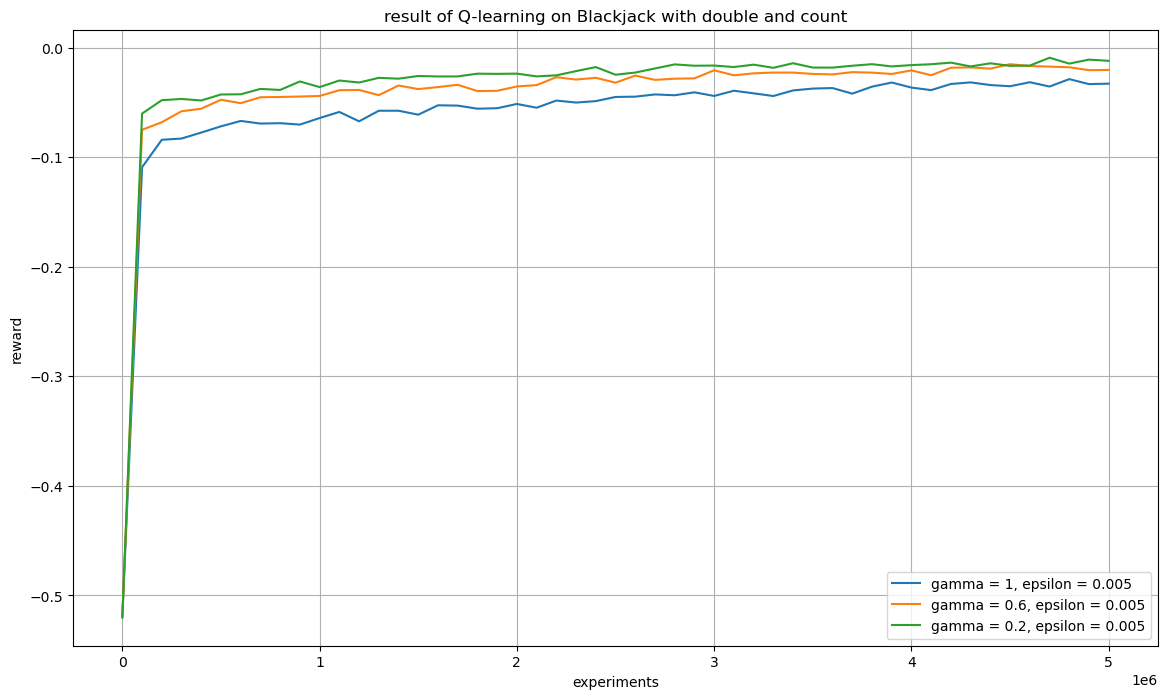

In [11]:
plot(results_dict, "result of Q-learning on Blackjack with double and count")